# Análisis de algoritmos de detección de comunidades sobre ego-networks de Facebook

## 1. Introducción

Para este trabajo decidí usar una serie de grafos extraídos de la red social Facebook. Estos grafos se pueden encontrar en el repositorio de Stanford Network Analysys Project ([SNAP](https://snap.stanford.edu/index.html)).

In [21]:
import numpy as np
import pandas as pd
import networkx as nx

En total son 10 archivos que contienen un grafo cada uno, a los cuales llaman la _"ego network"_ de un usuario $X$. La ego network de $X$ es generada agregando un nodo por cada amigo que tiene en la red social, y agregando ejes entre dos amigos $Y$ y $Z$ si son amigos entre sí.

La ego network del usuario $X$ la obtenemos del archivo "$X$.edges", el cual contiene un eje $(Y, Z)$ por línea.

In [22]:
ids = [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]
edge_lists = [ pd.read_csv("facebook/" + str(id) + ".edges",
                           sep=" ", header=None,
                           names=["source", "target"])
               for id in ids ]
edge_lists[0].head()

,source,target
0,236,186
1,122,285
2,24,346
3,271,304
4,176,9


In [23]:
graphs = [ nx.from_pandas_edgelist(edge_list)
           for edge_list in edge_lists ]

En el archivo de la ego network del usuario $X$ no se incluyen los ejes incidentes a él mismo, por lo tanto tampoco aparecerá el nodo que lo representa en el grafo. Entonces hay que agregar el nodo $X$ y sus ejes manualmente. Como todos los usuarios del grafo son amigos de $X$, se crea un nuevo nodo conectado a todos los demás.

In [24]:
def add_ego_nodes():
    for i, G in enumerate(graphs):
        G.add_node(ids[i])
        for node in G.nodes():
            if node != ids[i]:
                G.add_edge(ids[i], node)
add_ego_nodes()

## 2. Análisis
Empecemos con una exploración básica de los grafos.

In [25]:
df = pd.DataFrame({
    "id": ids,
    "nodes": [G.number_of_nodes() for G in graphs],
    "edges": [G.number_of_edges() for G in graphs],
})
df

,id,nodes,edges
0,0,334,2852
1,107,1035,27783
2,348,225,3416
3,414,151,1843
4,686,169,1824
5,698,62,331
6,1684,787,14810
7,1912,748,30772
8,3437,535,5347
9,3980,53,198


El dataset contiene grafos de entre 50 y 1.000 nodos, y entre 200 y 30.000 ejes. Para mejor visualización en las siguientes tablas y figuras voy a reordenarlo ascendentemente en cantidad de nodos.

In [26]:
df = df.sort_values(by="nodes", ascending=True)
ids = list(df["id"])
graphs = [graphs[i] for i in df.index]
df

,id,nodes,edges
9,3980,53,198
5,698,62,331
3,414,151,1843
4,686,169,1824
2,348,225,3416
0,0,334,2852
8,3437,535,5347
7,1912,748,30772
6,1684,787,14810
1,107,1035,27783


Las figuras de los grafos de ahora en más serán del primero (el más chico) ya que es el único con un tamaño razonable para representar visualmente.

### 2.1 Centralidad de nodos

Analicemos algunas medidas de centralidad vistas en clase

#### 2.1.1 Degree centrality
La _degree centrality_ de un nodo $v$ es la fracción de los nodos a los que está conectado. En este caso tendremos un nodo con _degree centrality_ máxima (igual a 1), que será el nodo $X$ que está conectado a todos los demás. Para cualquier otro nodo $Y$ sería una medida de cuántos amigos de $X$ también son amigos de $Y$.

En la ego network de 3980, su degree centrality es de 1.0


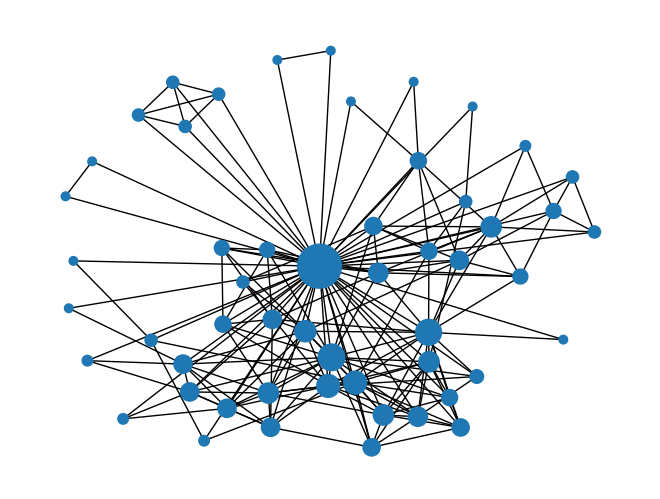

In [27]:
degree_centrality = nx.degree_centrality(graphs[0])
print(f"En la ego network de {ids[0]}, su degree centrality es de {degree_centrality[ids[0]]}")
pos = nx.spring_layout(graphs[0], seed=125)
nx.draw(graphs[0], pos,
        node_size=[degree_centrality[node]*1000 for node in graphs[0].nodes()])

#### 2.1.2 Eigenvector centrality
La _eigenvector centrality_ mide la influencia de un nodo $v$ en un grafo conexo. En nuestro caso los grafos siempre son conexos ya que en la ego network de $X$ siempre va a haber un camino de un nodo $Y$ a un nodo $Z$ ($Y$ -> $X$ -> $Z$). En el caso de tener grafos no conexos se puede usar un algoritmo como el de PageRank, que incluye un damping factor que permite saltos entre las distintas componentes conexas.

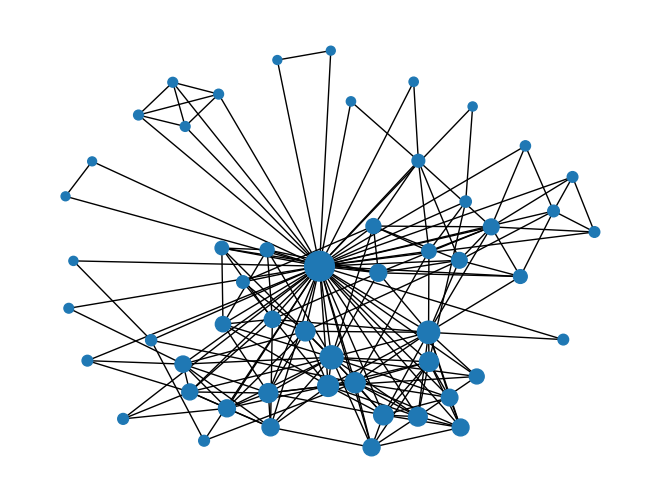

In [28]:
eigen_centrality = nx.eigenvector_centrality(graphs[0])
nx.draw(graphs[0], pos,
        node_size=[eigen_centrality[node]*1000 for node in graphs[0].nodes()])

Como era de esperar, el nodo $X$ otra vez es el que obtiene un valor más alto, ya que al tener conexiones con todos los demás, es el nodo que más influye en la red. Para los demás, el resultado de esta centralidad es muy similar al anterior, pero no idéntico. Esto se debe a que la _degree centrality_ tiene una correlación perfecta con el grado del nodo, sin embargo, la _eigenvector centrality_ tiene en cuenta otros factores; no es lo mismo estar conectado a un nodo de mayor valor (influencia) que a uno de menor valor.

Veamos qué tanto se correlaciona esta centralidad con el grado, y otra pregunta que me surgió es si se verá una tendencia al mirar esta correlación en función del tamaño de los grafos. Esperaría ver que para los grafos más chicos esta correlación sea más fuerte que para los grafos más grandes.

Primero a modo de prueba veamos que efectivamente la _degree centrality_ tiene una correlación perfecta con el grado: $degree\_centrality(v) = degree(v) * \frac{1}{|V|-1}$

In [29]:
from scipy import stats

info = pd.DataFrame({
    'degree': [val for (_, val) in graphs[0].degree()],
    'degree_centrality': [degree_centrality[node] for node in graphs[0].nodes()]})
print(stats.pearsonr(info['degree'], info['degree_centrality']))

PearsonRResult(statistic=0.9999999999999998, pvalue=0.0)


La correlación es perfecta. Ahora veamos la correlación del grado con la _eigen centrality_ para los 10 grafos.

In [30]:
correlations = []
pvalues = []
for i, id in enumerate(ids):
    eigen_centrality = nx.eigenvector_centrality(graphs[i])
    info = pd.DataFrame({
        'degree': [val for (_, val) in graphs[i].degree()],
        'eigen_centrality': [eigen_centrality[node] for node in graphs[i].nodes()]})
    corr, pval = stats.pearsonr(info['degree'], info['eigen_centrality'])
    correlations.append(corr)
    pvalues.append(pval)
df["correlation"] = correlations
df["pvalue"] = pvalues
df

,id,nodes,edges,correlation,pvalue
9,3980,53,198,0.935738,9.799254e-25
5,698,62,331,0.861401,2.639286e-19
3,414,151,1843,0.779670,4.266949e-32
4,686,169,1824,0.933118,4.321188e-76
2,348,225,3416,0.936674,1.375132e-103
0,0,334,2852,0.842201,4.428020e-91
8,3437,535,5347,0.783904,2.076072e-112
7,1912,748,30772,0.808457,6.587713e-174
6,1684,787,14810,0.761879,3.241023e-150
1,107,1035,27783,0.826881,1.800984e-260


Para todos los grafos se ve una correlación alta entre los grados y las _eigenvector centrality_, pero ya no es perfecta. Con respecto a la pregunta de cómo afecta el tamaño del nodo a esta correlación, podemos ver que las 3 correlaciones más fuertes son de $0.93$, y vienen de grafos de 53, 169 y 225 nodos, tres de los cinco grafos más chicos. Sin embargo, no hay una tendencia muy marcada de que al aumentar el tamaño del grafo disminuya mucho esta correlación.

#### 2.1.3 Closeness centrality
La _closeness centrality_ mide que tan cerca está un nodo de todos los demás. En estos grafos esta medida no tiene sentido ya que todos los nodos van a estar a distancia 1 o 2 de todos los demás: 1 si tienen un eje entre ellos, 2 si no.

#### 2.1.4 Betweenness centrality
La _betweenness centrality_ cuenta cuántos de los caminos entre todo par de nodos pasan por el nodo $v$. En este caso tampoco tiene sentido medirla ya que casi todos los caminos mínimos pasarán sólo por $X$ (todos menos los caminos entre nodos que son amigos entre sí). Por lo tanto todos tendran _betweenness centrality_ muy bajo mientras que $X$ muy alto.

### 2.2 Edge betweenness centrality

Esta medida es igual a la de centralidad de nodos pero aplicada a los ejes (cantidad de caminos mínimos que pasan por cada eje). Como muchos caminos mínimos serán los de tamaño igual a 2 que pasan por $X$, todas las aristas incidentes a $X$ son las que van a obtener mayor centrality.

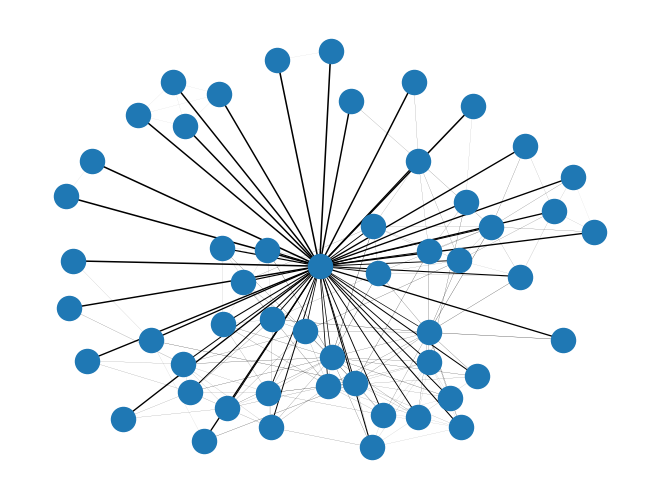

In [31]:
nx.draw(graphs[0], pos, width=[width*30 for width in list(nx.edge_betweenness_centrality(graphs[0]).values())])

## 3. Comunidades

Además de las ego networks, tenemos los datos de los _"círculos"_ del usuario $X$. Los círculos son grupos de amigos definidos por el mismo usuario -por ejemplo podrías agrupar tus amigos en 3 círculos para la secundaria, universidad y trabajo-.
En esta sección vamos a comparar distintos algoritmos de detección de comunidades vistos en clase sobre estos grafos, buscando aquel que mejor pueda distinguir los círculos de amigos de los usuarios.

In [32]:
circles = []
for i, id in enumerate(ids):
    with open("facebook/" + str(id) + ".circles", "r") as file:
        circles.append([])
        circles[i].append([id])
        for circle, line in enumerate(file):
            circle_ids = [int(id) for id in line.strip().split("\t")[1:]]
            circles[i].append([id for id in circle_ids if id in graphs[i].nodes()])
            for id in circle_ids:
                if id in graphs[i].nodes():
                    graphs[i].nodes[id]["circle"] = circle
        circle += 1
        for node in graphs[i].nodes():
            if "circle" not in graphs[i].nodes[node]:
                graphs[i].nodes[node]["circle"] = circle
                circles[i].append([node])
                circle += 1

Veamos un ejemplo de los círculos en un grafo:

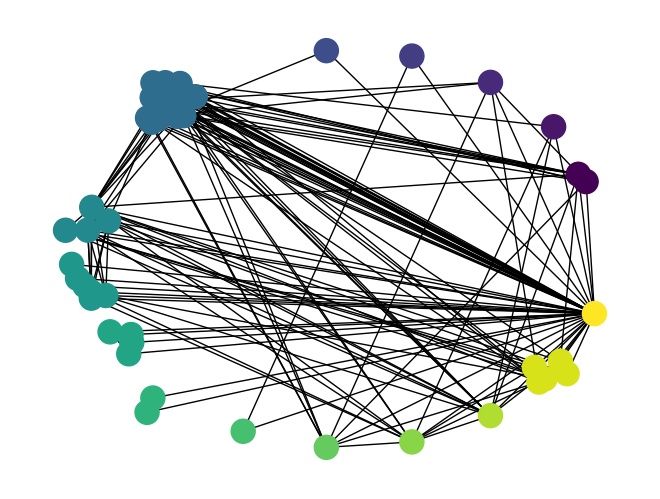

In [33]:
supergraph = nx.cycle_graph(len(circles[0]))
superpos = nx.circular_layout(supergraph)
centers = list(superpos.values())

pos = {}
for i, circle in enumerate(circles[0]):
    color = np.random.uniform(0, 1, 3)
    for node in circle:
        pos[node] = np.array(centers[i])
        if len(circle) > 1: pos[node] += np.random.uniform(-0.1, 0.1, 2)

nx.draw(graphs[0], pos=pos, node_color=[graphs[0].nodes[node]["circle"] for node in graphs[0].nodes()])

### 3.1 Label Propagation
El primer algoritmo a probar es el de Label Propagation por su simpleza. En este algoritmo todos los nodos comienzan siendo su propia comunidad (también sirve para semi-supervisado, donde algunos ya tienen comunidad asignada, pero no es el caso) y se van actualizando en base a las comunidades de los vecinos. Para un órden aleatorio de los nodos, se los recorre y se le asigna a cada nodo la comunidad más común entre sus vecinos. Esto se repite hasta que todos están en la comunidad más común entre sus vecinos.

In [34]:
for G in graphs:
    communities = nx.community.label_propagation_communities(G)
    print(len(communities), end=" ")

1 1 1 1 1 1 1 1 1 1 

Al correr este algoritmo sobre los grafos obtenemos una sóla comunidad con todos los nodos para todos los grafos. Mi hipótesis es que esto se debe a que inicialmente muchos van a tomar el color de $X$, posteriormente propagando este color mucho más que los demás, llegando finalmente a todos. Para solucionar esto eliminaré el nodo $X$ de los grafos.

In [35]:
def remove_ego_nodes():
    for i, id in enumerate(ids):
        graphs[i].remove_node(id)
remove_ego_nodes()

In [36]:
for G in graphs:
    communities = nx.community.label_propagation_communities(G)
    print(len(communities), end=" ")
    for i, community in enumerate(communities):
        for node in community:
            G.nodes[node]["label_propagation_community"] = i

7 6 4 6 9 21 16 12 14 19 

Una vez eliminado $X$, obtenemos una cantidad razonable de comunidades al ejecutar el algoritmo. Veamos cómo quedaron en el último grafo.

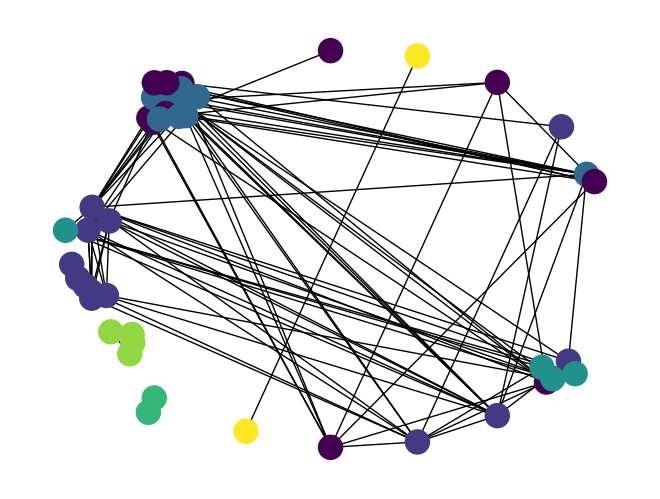

In [37]:
nx.draw(graphs[0], pos=pos, node_color=[graphs[0].nodes[node]["label_propagation_community"] for node in graphs[0].nodes()])

A simple vista el resultado no es nada malo para lo simple que es el algoritmo. Las comunidades encontradas sin dudas tienen una conexión con los círculos creados por el usuario. Al final de esta sección se hará un análisis más riguroso para todos los algoritmos.

Los nodos amarillos sólo están conectados entre ellos, por lo tanto lógicamente terminaron en la misma comunidad. Si bien el usuario los puso en círculos separados, quizás por haberlos conocido en situaciones distintas, estos usuarios se conocían entre sí, así que tiene sentido que el algoritmo los termine poniendo en la misma comunidad.

### 3.2 Girvan-Newman
El segundo algoritmo a probar será el de Girvan Newman. Este algoritmo va eliminando aquellos ejes con mayor _betweenness centrality_, rompiendo así el grafo de a poco entre distintas componentes conexas las cuales se toman como comunidades, resultando en un dendograma.

In [38]:
for G in graphs:
    communities = nx.community.girvan_newman(G)
    i = 0
    for community in next(communities):
        for node in community:
            G.nodes[node]["girvan_newman_community"] = i
        i += 1

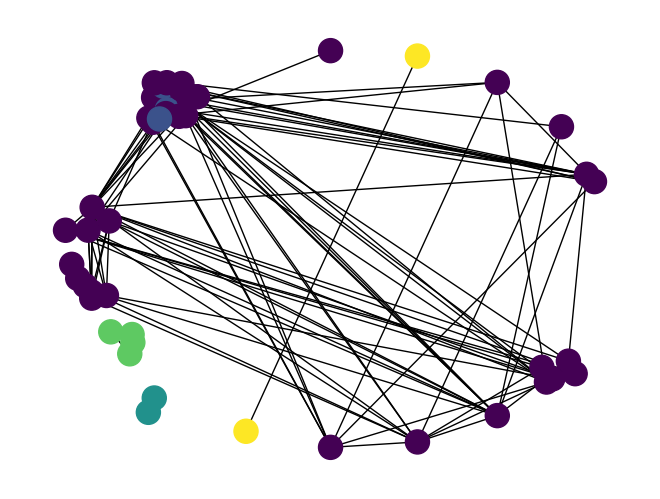

In [39]:
nx.draw(graphs[0], pos=pos, node_color=[graphs[0].nodes[node]["girvan_newman_community"] for node in graphs[0].nodes()])

A simple vista el resultado parece peor que el de Label Propagation. Otra cosa a tener en cuenta es que si bien todos los demás algoritmos se ejecutaron instantaneamente en todos los grafos, este tardó 6 minutos en ejecutar en total. No voy a incluir experimentos ni figuras de mediciones de tiempo porque no vienen al caso, pero es importante mencionarlo.

### 3.3 Louvain
El tercer algoritmo a probar es el de Louvain. En este algoritmo cada nodo empieza en su propia comunidad. Luego en un primer paso, para cada nodo $v$ se fija, para cada nodo de su vecindario, si moverlo a la comunidad de sus vecinos resulta en una ganancia de modularidad. En el caso de que haya ganancia, se mueve al que mayor ganancia tenga. En el segundo paso se genera un nuevo grafo creando un nodo por cada comunidad y agregando aristas pesadas si hay aristas entre nodos de distintas comunidades. Estos dos pasos se ejecutan iterativamente. 

In [40]:
for G in graphs:
    communities = nx.community.louvain_communities(G)
    for i, community in enumerate(communities):
        for node in community:
            G.nodes[node]["louvain_community"] = i

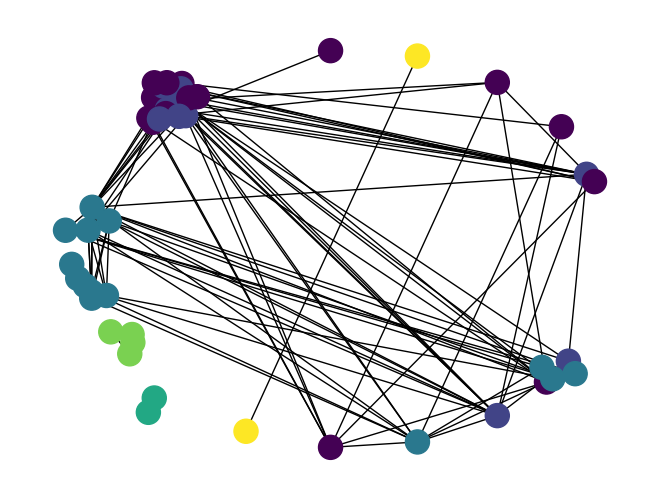

In [41]:
nx.draw(graphs[0], pos=pos, node_color=[graphs[0].nodes[node]["louvain_community"] for node in graphs[0].nodes()])

Al igual que Label Propagation, el resultado parece bueno.

### 3.4 Affinity Propagation

El cuarto algoritmo a probar es el de Affinity Propagation. Este algoritmo se basa en el envío de mensajes entre nodos del grafo para identificar los centros de los clusters. Para esto usa ejemplares (nodos que representan otros nodos dentro del mismo cluster).

In [42]:
from sklearn.cluster import AffinityPropagation

In [43]:
for G in graphs:
    communities = AffinityPropagation(max_iter=1000).fit(nx.to_numpy_array(G))
    for node, label in zip(G.nodes(), communities.labels_):
        G.nodes[node]["affinity_propagation_community"] = label

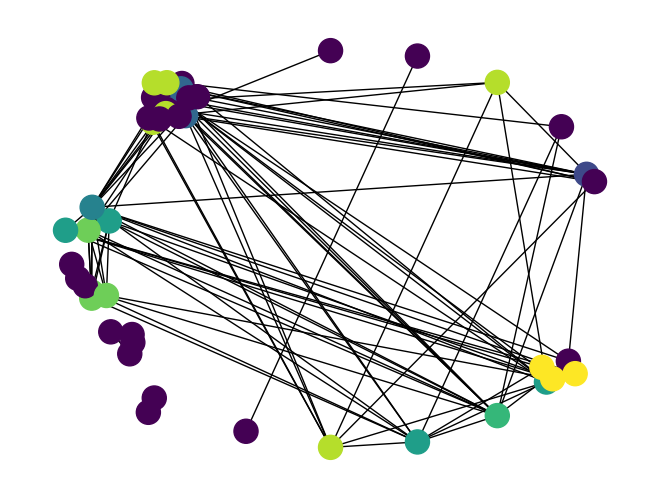

In [44]:
nx.draw(graphs[0], pos=pos, node_color=[graphs[0].nodes[node]["affinity_propagation_community"] for node in graphs[0].nodes()])

Al igual que Girvan-Newman, el algoritmo parece malo para este caso de uso.

### 3.5 Markov Clustering

El último algoritmo a probar es el de Markov Clustering. Este se basa en una simulación de flujo estocástico sobre el grafo. La idea principal es que si haces una caminata aleatoria en un grafo, podrías descubrir donde se suele quedar atrapado el flujo, descubriendo así los clusters. 

In [45]:
import markov_clustering as mc

In [46]:
for G in graphs:
    result = mc.run_mcl(nx.to_numpy_array(G))
    clusters = mc.get_clusters(result)
    node_list = list(G.nodes())
    for i, community in enumerate(clusters):
        for node_index in community:
            G.nodes[node_list[node_index]]["markov_clustering_community"] = i

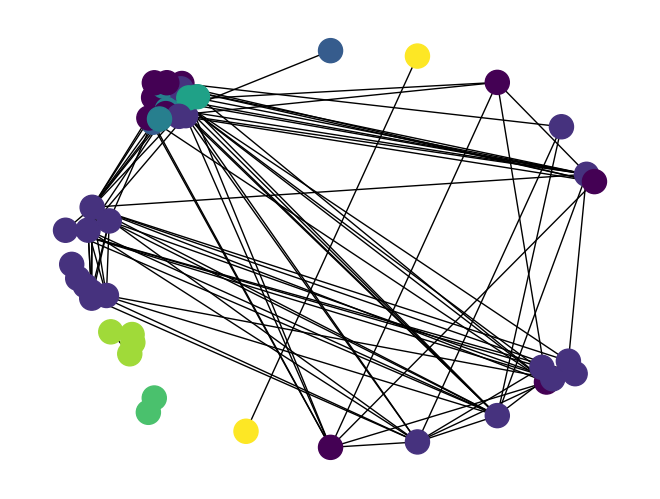

In [47]:
nx.draw(graphs[0], pos=pos, node_color=[graphs[0].nodes[node]["markov_clustering_community"] for node in graphs[0].nodes()])

A simple vista parece obtener un buen resultado, quizás algo peor que Label Propagation y Louvain, pero considerablemente mejor que Girvan-Newman y Affinity Propagation.

### 3.6 Métricas de comparación de clusterings

Algo que no se vio en la materia y me pareció interesante investigar es, teniendo un dataset con los clusters que se saben que son correctos _"ground truth clusters"_, cómo medir qué tan bueno/acertado es cierto clustering obtenido al correr un algoritmo.

Para esto hay distintas métricas que se pueden calcular:

#### 3.6.1 Rand Index

Rand Index es la métrica más simple e intuitiva. Para calcular este puntaje siplemente se consideran todos los pares de nodos $(v, w)$ y se evalúa si están asignados al mismo o a diferentes clusters tanto en la predicción como en el ground truth. Matemáticamente se podría escribir como:

$RI = \frac{TP + TN}{TP+TN+FP+FN}$, donde:
- $TP$ son los pares que están en el mismo cluster en la predicción y en el ground truth.
- $TN$ son los pares que están en distintos clusters en la predicción y en el ground truth.
- $FP$ son los pares que están en el mismo cluster en la predicción pero en distintos en el ground truth.
- $FN$ son los pares que están en distintos clusters en la predicción pero en el mismo en el ground tuth.

La principal desventaja de esta métrica es que está sesgada por los clusters grandes -si hay uno muy grande y es correctamente identificado, el puntaje será alto, sin importar los demás clusters más pequeños-.

In [48]:
from sklearn.metrics.cluster import rand_score

In [49]:
ground_truths = [[G.nodes[node]["circle"] for node in G.nodes()] for G in graphs]
algorithms = ["label_propagation", "girvan_newman", "louvain", "affinity_propagation", "markov_clustering"]

for algorithm in algorithms:
    scores = []
    for i, G in enumerate(graphs):
        communities = [G.nodes[node][algorithm + "_community"] for node in G.nodes()]
        scores.append(rand_score(ground_truths[i], communities))
    df[algorithm + "_rand_index"] = scores

In [50]:
import matplotlib.pyplot as plt

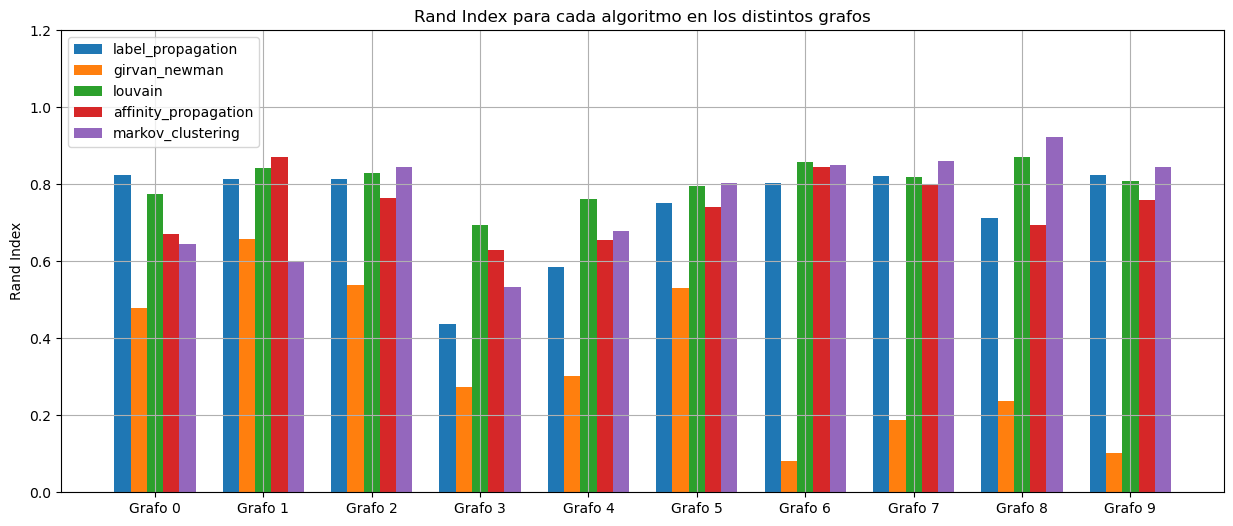

In [51]:
fig, ax = plt.subplots(figsize=(15, 6))

width = 0.15
x = np.arange(10)

for i, algorithm in enumerate(algorithms):
    ax.bar(x + i * width, df[algorithm+"_rand_index"], width, label=algorithm)
plt.legend(algorithms)

ax.set_ylim(0, 1.2)
ax.set_title('Rand Index para cada algoritmo en los distintos grafos')
ax.set_ylabel('Rand Index')
ax.set_xticks(x + (len(algorithms) / 2 - 0.5) * width)
ax.set_xticklabels([f'Grafo {i}' for i in range(len(df))])
plt.grid()
plt.show()  

En esta figura podemos ver que en base a esta métrica, en los grafos más chicos (0- 5) el método más consistente es el de Louvain, obteniendo consistentemente scores máximos o próximos al máximo. Por otro lado, en los grafos más grandes (5-9) el mejor método parece ser el de Markov Clustering. El método de Girvan-Newman es el que peor performance tuvo para todos los grafos. Finalmente, los métodos de Label Propagation y Affinity Propagation obtienen un buen resultado en general, pero rara vez llegando al máximo y con más varianza que los otros.

#### 3.6.2 Mutual Information
Esta métrica está basada en la teoría de la información. Es una medida de la dependencia mutua entre dos variables. Más especificamente, cuantifica la "cantidad de información" que se obtiene de una variable aleatoria al observar la otra.

La ventaja de esta métrica es que maneja mejor los casos en los que tenemos clusters de distintos tamaños.

In [52]:
from sklearn.metrics import normalized_mutual_info_score

In [53]:
for algorithm in algorithms:
    scores = []
    for i, G in enumerate(graphs):
        communities = [G.nodes[node][algorithm + "_community"] for node in G.nodes()]
        scores.append(normalized_mutual_info_score(ground_truths[i], communities))
    df[algorithm + "_mutual_info"] = scores

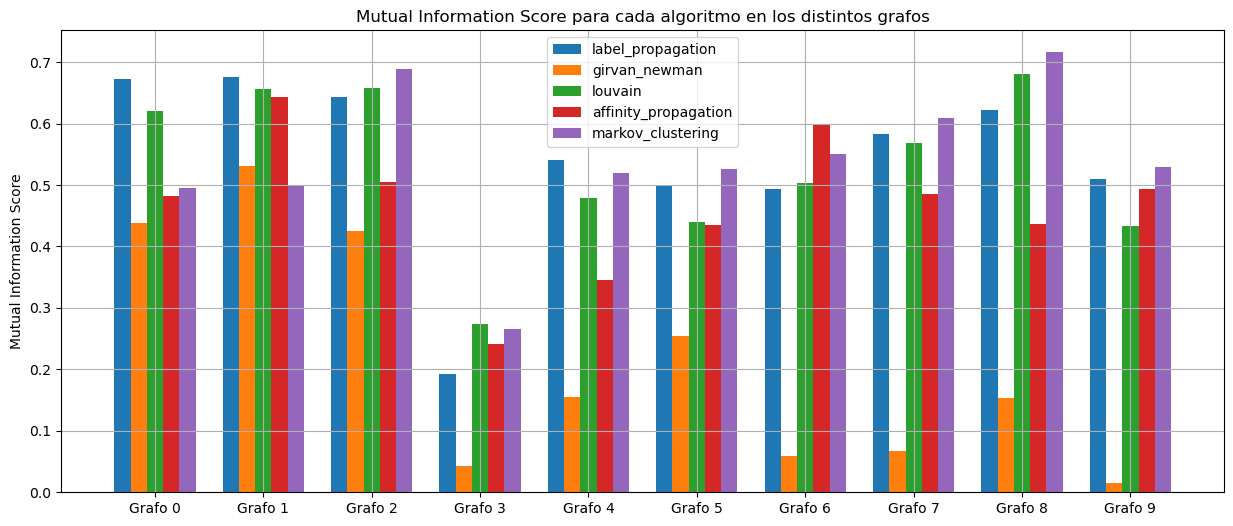

In [54]:
fig, ax = plt.subplots(figsize=(15, 6))

width = 0.15
x = np.arange(10)

for i, algorithm in enumerate(algorithms):
    ax.bar(x + i * width, df[algorithm+"_mutual_info"], width, label=algorithm)
plt.legend(algorithms)


ax.set_title('Mutual Information Score para cada algoritmo en los distintos grafos')
ax.set_ylabel('Mutual Information Score')
ax.set_xticks(x + (len(algorithms) / 2 - 0.5) * width)
ax.set_xticklabels([f'Grafo {i}' for i in range(len(df))])
plt.grid()
plt.show()  

En esta figura vemos que en los grafos grandes otra vez el método de Markov Clustering es el que obtiene mejores resultados y más consistentemente. Además, en este caso en los grafos 2, 3 y 4 obtiene mejores resultados en relación a los demás que con la métrica anterior. El método de Louvain sigue dando buenos resultados en los chicos pero se vuelve incluso más incosistente en los grafos más grandes, no parece adecuado. El método de Affinity Propagation si bien en ciertos casos tuvo buenos resultados, en general es malo y casi siempre pierde con Label Propagation, el cual es sorprendentemente bueno para lo simple que es. Nuevamente con esta otra métrica el método de Girvan-Newman da muy malos resultados.

Como conclusión de esta sección agregaría que, como los círculos de amigos son de diversos tamaños, la métrica adecuada para este caso de uso es la de Mutual Information. Mirando los resultados de los algoritmos en base a esta métrica se ve que el algoritmo que mejor modela este caso es el de Markov Clustering.